# Stage 1: Unseen Dataset Evaluation
## LSTM Baseline — LOS/NLOS Classification

This notebook loads the trained Stage 1 LSTM model (`stage1_lstm_best.pt`) and evaluates it on a **completely unseen dataset** containing 4 scenarios never used during training:

| Scenario | Type | d_direct | d_bounce | Samples |
|----------|------|----------|----------|--------|
| 8.91m | NLOS | 6.10m | 8.91m | 600 |
| 9.54m | NLOS | 7.668m | 9.54m | 600 |
| 10.19m | LOS | 10.19m | — | 600 |
| 9.29m | LOS | 9.29m | — | 600 |

**Total: 2400 samples (1200 LOS + 1200 NLOS), perfectly balanced.**

**Key difference from LNN**: LSTM processes raw CIR only — no FP_AMPL conditioning, no tau dynamics.

In [1]:
CONFIG = {
    "pre_crop": 10,
    "post_crop": 50,
    "total_len": 60,
    "search_start": 740,
    "search_end": 890,
    "hidden_size": 64,
    "input_size": 1,
    "dropout": 0.2,
    "batch_size": 64,
    "seed": 42,
}

In [2]:
import copy
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, roc_curve, auc
)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
torch.manual_seed(CONFIG["seed"])
np.random.seed(CONFIG["seed"])

Device: cuda


## 1 · Model Architecture
Identical definition from the training notebook — required to load the `.pt` weights.

**No FP_AMPL conditioning** — standard zero-init h₀/c₀.
**Average pooling** — time-averaged LSTM trajectory, matching the LNN.

In [3]:
class LSTM_Classifier(nn.Module):
    """
    Standard LSTM baseline with average pooling.
    No FP_AMPL conditioning — processes raw CIR only.

    Average pooling design: the classifier sees the time-averaged LSTM hidden
    trajectory mean(h_all, dim=1). This matches the LNN's average pooling
    readout for a fair apples-to-apples comparison.
    """
    def __init__(self, input_size=1, hidden_size=64, dropout=0.2):
        super().__init__()
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
        )

        # Classifier head (same as LNN)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x_seq, return_dynamics=False):
        batch_size = x_seq.size(0)

        # Standard zero-initialised h0/c0
        h0 = torch.zeros(1, batch_size, self.hidden_size, device=x_seq.device)
        c0 = torch.zeros(1, batch_size, self.hidden_size, device=x_seq.device)

        h_all, (h_n, c_n) = self.lstm(x_seq, (h0, c0))  # (B, 60, 64)

        # Average pooling — time-averaged trajectory
        h_avg = h_all.mean(dim=1)  # (B, 64)

        pred = self.classifier(h_avg)

        if return_dynamics:
            return pred, h_all
        return pred

    def embed(self, x_seq):
        """Return 64-dim embedding for Stage 2/3 compatibility."""
        batch_size = x_seq.size(0)
        h0 = torch.zeros(1, batch_size, self.hidden_size, device=x_seq.device)
        c0 = torch.zeros(1, batch_size, self.hidden_size, device=x_seq.device)
        h_all, _ = self.lstm(x_seq, (h0, c0))
        return h_all.mean(dim=1)  # (B, 64) — time-averaged trajectory

## 2 · Load Unseen Dataset
Same preprocessing as training: RXPACC normalization → leading-edge alignment → 60-sample crop → instance normalization to [0,1].

**No FP_AMPL features** — LSTM processes raw CIR only.

In [4]:
def get_roi_alignment(sig, search_start=CONFIG["search_start"],
                      search_end=CONFIG["search_end"]):
    """
    Find the leading edge of the pulse by backtracking from peak.
    Uses noise floor estimation (mean + 3*std) or 5% of peak.
    """
    region = sig[search_start:search_end]
    if len(region) == 0:
        return np.argmax(sig)

    peak_local = np.argmax(region)
    peak_idx = search_start + peak_local
    peak_val = sig[peak_idx]

    # Noise floor from samples before the search region
    noise_section = sig[:search_start]
    if len(noise_section) > 10:
        noise_mean = np.mean(noise_section)
        noise_std = np.std(noise_section)
        threshold = max(noise_mean + 3 * noise_std, 0.05 * peak_val)
    else:
        threshold = 0.05 * peak_val

    # Backtrack from peak to find leading edge
    leading_edge = peak_idx
    for i in range(peak_idx, max(search_start - 20, 0), -1):
        if sig[i] < threshold:
            leading_edge = i + 1
            break

    return leading_edge


def load_unseen_dataset(filepath):
    """Load and preprocess the unseen dataset — CIR only, no FP features."""
    PRE = CONFIG["pre_crop"]
    POST = CONFIG["post_crop"]
    TOTAL = CONFIG["total_len"]

    df = pd.read_csv(filepath)
    print(f"Loaded {len(df)} rows from {filepath}")

    cir_cols = sorted(
        [c for c in df.columns if c.startswith("CIR")],
        key=lambda c: int(c.replace("CIR", ""))
    )

    X_list, y_list = [], []
    source_files = []
    skipped = 0

    for _, row in df.iterrows():
        sig = pd.to_numeric(row[cir_cols], errors='coerce').fillna(0).astype(float).values

        rxpacc_col = 'RXPACC' if 'RXPACC' in row.index else 'RX_PACC'
        rxpacc = float(row.get(rxpacc_col, 128.0))
        if rxpacc <= 0:
            skipped += 1
            continue

        sig = sig / rxpacc

        leading_edge = get_roi_alignment(sig)

        start = max(0, leading_edge - PRE)
        end = start + TOTAL
        if end > len(sig):
            end = len(sig)
            start = max(0, end - TOTAL)

        crop = sig[start:end]
        if len(crop) < TOTAL:
            crop = np.pad(crop, (0, TOTAL - len(crop)), mode='constant')

        local_min = np.min(crop)
        local_max = np.max(crop)
        rng = local_max - local_min
        if rng > 0:
            crop = (crop - local_min) / rng
        else:
            crop = np.zeros(TOTAL)

        X_list.append(crop)
        y_list.append(float(row["Label"]))
        source_files.append(row["Source_File"])

    if skipped:
        print(f"Skipped {skipped} rows (bad RXPACC)")

    X = np.array(X_list, dtype=np.float32).reshape(-1, TOTAL, 1)
    y = np.array(y_list, dtype=np.float32)

    print(f"Preprocessed: {len(y)} samples  |  LOS: {int((y==0).sum())}  |  NLOS: {int((y==1).sum())}")
    return X, y, source_files

In [5]:
X_unseen, y_unseen, sources = load_unseen_dataset(
    "../dataset/channels/unseen_dataset.csv"
)

Loaded 2400 rows from ../dataset/channels/unseen_dataset.csv
Preprocessed: 2400 samples  |  LOS: 1200  |  NLOS: 1200


## 3 · Load Trained Model

In [6]:
model = LSTM_Classifier(
    input_size=CONFIG["input_size"],
    hidden_size=CONFIG["hidden_size"],
    dropout=CONFIG["dropout"],
).to(device)

state_dict = torch.load("stage1_lstm_best.pt", map_location=device, weights_only=True)
model.load_state_dict(state_dict)
model.eval()

total_params = sum(p.numel() for p in model.parameters())
print(f"Model loaded: {total_params:,} parameters")

Model loaded: 19,265 parameters


## 4 · Inference on Unseen Data

In [7]:
X_te = torch.tensor(X_unseen).to(device)
y_te = torch.tensor(y_unseen).unsqueeze(1).to(device)

with torch.no_grad():
    pred = model(X_te)
    pred_binary = (pred > 0.5).float()
    accuracy = (pred_binary == y_te).float().mean().item()

pred_np = pred.cpu().numpy().flatten()
pred_label_np = (pred_np > 0.5).astype(float)
true_np = y_unseen.flatten()

print(f"Unseen Dataset Accuracy: {100 * accuracy:.2f}%")
print(f"{'='*50}")
print(classification_report(true_np, pred_label_np, target_names=["LOS", "NLOS"]))

Unseen Dataset Accuracy: 78.46%
              precision    recall  f1-score   support

         LOS       0.80      0.77      0.78      1200
        NLOS       0.77      0.80      0.79      1200

    accuracy                           0.78      2400
   macro avg       0.78      0.78      0.78      2400
weighted avg       0.78      0.78      0.78      2400



## 5 · Per-Scenario Breakdown

In [8]:
sources_arr = np.array(sources)

# Extract scenario prefix (e.g. "8.91m_nlos" from "8.91m_nlos_c1.csv")
scenario_names = np.array(["_".join(s.split("_")[:2]) for s in sources_arr])
unique_scenarios = sorted(set(scenario_names))

print(f"{'Scenario':<16} {'Type':<6} {'Samples':>7} {'Correct':>8} {'Accuracy':>9}")
print("-" * 52)

for scenario in unique_scenarios:
    mask = scenario_names == scenario
    s_true = true_np[mask]
    s_pred = pred_label_np[mask]
    s_correct = (s_true == s_pred).sum()
    s_total = len(s_true)
    s_acc = s_correct / s_total * 100
    s_type = "NLOS" if "nlos" in scenario else "LOS"
    print(f"{scenario:<16} {s_type:<6} {s_total:>7} {s_correct:>8} {s_acc:>8.2f}%")

print("-" * 52)
print(f"{'TOTAL':<16} {'':6} {len(true_np):>7} {int((true_np == pred_label_np).sum()):>8} {100*accuracy:>8.2f}%")

Scenario         Type   Samples  Correct  Accuracy
----------------------------------------------------
10.19m_los       LOS        600      418    69.67%
8.91m_nlos       NLOS       600      425    70.83%
9.29m_los        LOS        600      501    83.50%
9.54m_nlos       NLOS       600      539    89.83%
----------------------------------------------------
TOTAL                      2400     1883    78.46%


## 6 · Confusion Matrix

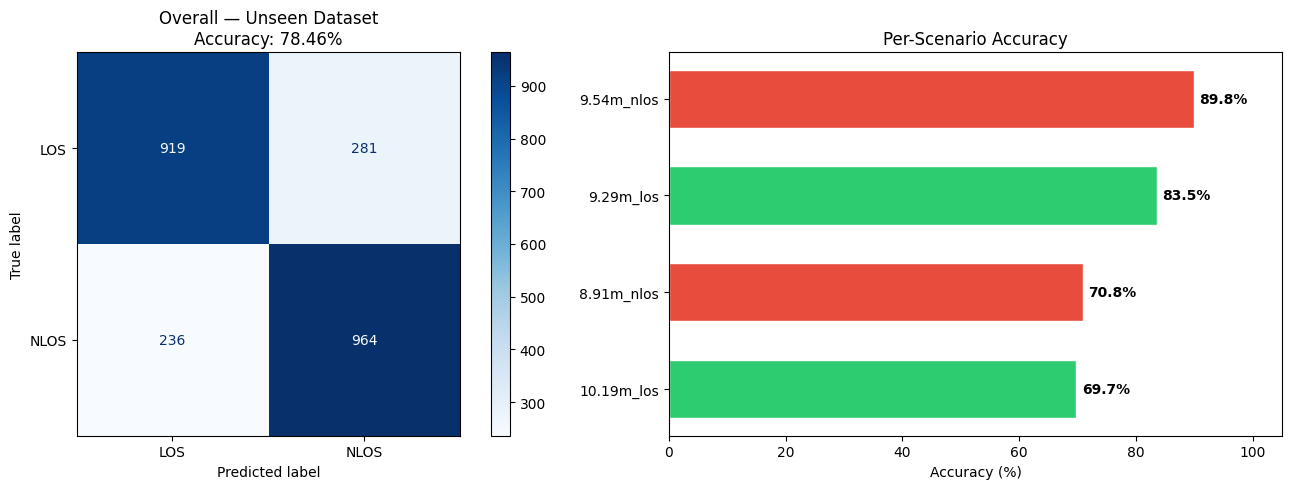

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall confusion matrix
cm = confusion_matrix(true_np, pred_label_np)
disp = ConfusionMatrixDisplay(cm, display_labels=["LOS", "NLOS"])
disp.plot(ax=axes[0], cmap="Blues", values_format="d")
axes[0].set_title(f"Overall — Unseen Dataset\nAccuracy: {100*accuracy:.2f}%")

# Per-scenario accuracy bar chart
scenario_labels, scenario_accs, scenario_colors = [], [], []
for scenario in unique_scenarios:
    mask = scenario_names == scenario
    s_acc = (true_np[mask] == pred_label_np[mask]).mean() * 100
    scenario_labels.append(scenario)
    scenario_accs.append(s_acc)
    scenario_colors.append("#2ecc71" if "los" in scenario and "nlos" not in scenario else "#e74c3c")

bars = axes[1].barh(scenario_labels, scenario_accs, color=scenario_colors, edgecolor="white", height=0.6)
axes[1].set_xlim(0, 105)
axes[1].set_xlabel("Accuracy (%)")
axes[1].set_title("Per-Scenario Accuracy")
for bar, acc in zip(bars, scenario_accs):
    axes[1].text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                 f"{acc:.1f}%", va="center", fontweight="bold")

plt.tight_layout()
plt.show()

## 7 · ROC Curve

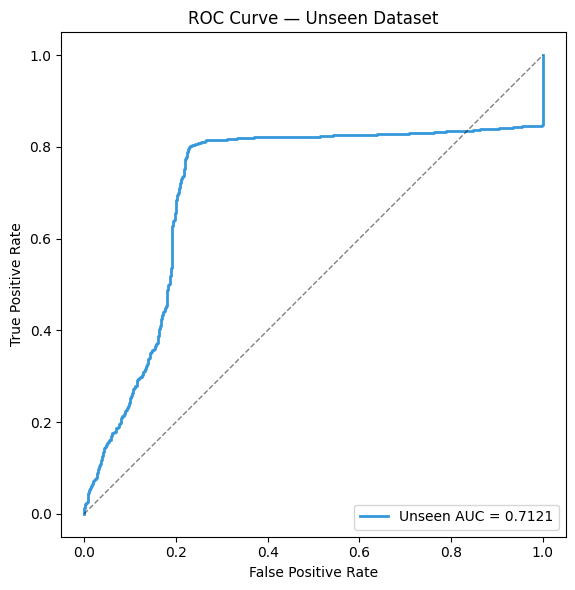

In [10]:
fpr, tpr, _ = roc_curve(true_np, pred_np)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(fpr, tpr, color="#3498db", lw=2, label=f"Unseen AUC = {roc_auc:.4f}")
ax.plot([0, 1], [0, 1], "k--", lw=1, alpha=0.5)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curve — Unseen Dataset")
ax.legend(loc="lower right")
ax.set_aspect("equal")
plt.tight_layout()
plt.show()

## 8 · Confusion Matrix + Embedding Visualization

The 64-dim average-pooled embedding from the LSTM is projected to 2D via PCA. Each point is colored by its confusion matrix category (TN, TP, FP, FN) so the scatter plot maps directly to the confusion matrix.

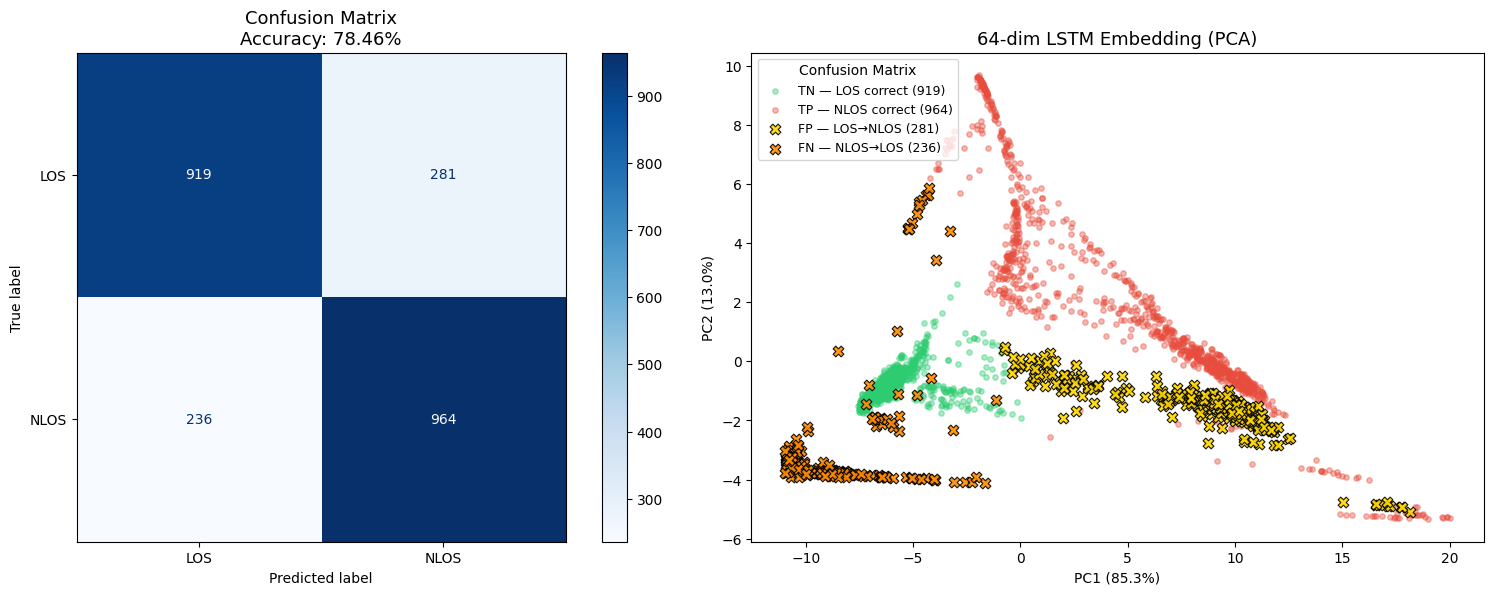

TN: 919 | FP: 281 | TP: 964 | FN: 236 | Total: 2400


In [11]:
los_mask = true_np == 0
nlos_mask = true_np == 1

with torch.no_grad():
    embeddings = model.embed(X_te).cpu().numpy()

scaler = StandardScaler()
emb_scaled = scaler.fit_transform(embeddings)
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(emb_scaled)

# Confusion matrix categories
misclassified = true_np != pred_label_np
los_correct = los_mask & ~misclassified    # TN
los_wrong = los_mask & misclassified       # FP
nlos_correct = nlos_mask & ~misclassified  # TP
nlos_wrong = nlos_mask & misclassified     # FN

tn = int(los_correct.sum())
fp = int(los_wrong.sum())
tp = int(nlos_correct.sum())
fn = int(nlos_wrong.sum())

# --- Side-by-side: Confusion Matrix + PCA Embedding ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Confusion Matrix
cm = confusion_matrix(true_np, pred_label_np)
disp = ConfusionMatrixDisplay(cm, display_labels=["LOS", "NLOS"])
disp.plot(ax=axes[0], cmap="Blues", values_format="d")
axes[0].set_title(f"Confusion Matrix\nAccuracy: {100*accuracy:.2f}%", fontsize=13)

# Right: Clean PCA scatter
ax = axes[1]

ax.scatter(emb_2d[los_correct, 0], emb_2d[los_correct, 1],
           c="#2ecc71", alpha=0.4, s=15,
           label=f"TN — LOS correct ({tn})", zorder=3)
ax.scatter(emb_2d[nlos_correct, 0], emb_2d[nlos_correct, 1],
           c="#e74c3c", alpha=0.4, s=15,
           label=f"TP — NLOS correct ({tp})", zorder=3)
if fp > 0:
    ax.scatter(emb_2d[los_wrong, 0], emb_2d[los_wrong, 1],
               c="gold", marker='X', s=60, edgecolors='black', linewidths=0.8,
               alpha=0.9, label=f"FP — LOS\u2192NLOS ({fp})", zorder=7)
if fn > 0:
    ax.scatter(emb_2d[nlos_wrong, 0], emb_2d[nlos_wrong, 1],
               c="darkorange", marker='X', s=60, edgecolors='black', linewidths=0.8,
               alpha=0.9, label=f"FN — NLOS\u2192LOS ({fn})", zorder=7)

ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
ax.set_title("64-dim LSTM Embedding (PCA)", fontsize=13)
ax.legend(loc="upper left", fontsize=9, title="Confusion Matrix", title_fontsize=10)

plt.tight_layout()
plt.show()

print(f"TN: {tn} | FP: {fp} | TP: {tp} | FN: {fn} | Total: {tn+fp+tp+fn}")

## 9 · Prediction Confidence Distribution

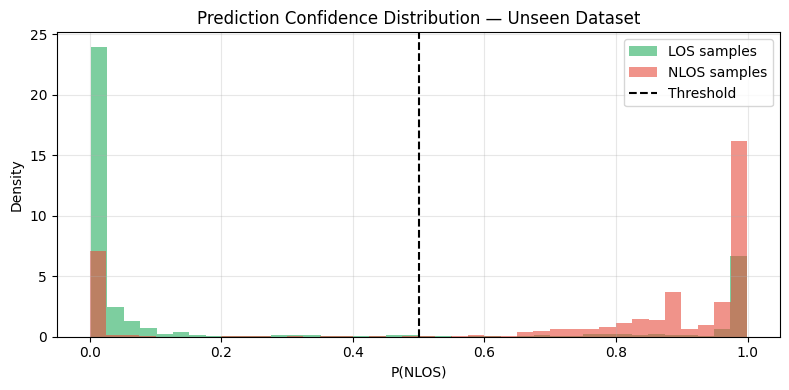

In [12]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.hist(pred_np[true_np == 0], bins=40, alpha=0.6, color="#27ae60",
        label="LOS samples", density=True)
ax.hist(pred_np[true_np == 1], bins=40, alpha=0.6, color="#e74c3c",
        label="NLOS samples", density=True)
ax.axvline(0.5, color="black", ls="--", lw=1.5, label="Threshold")
ax.set_xlabel("P(NLOS)")
ax.set_ylabel("Density")
ax.set_title("Prediction Confidence Distribution — Unseen Dataset")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10 · Misclassified Samples Analysis

In [13]:
misclassified = true_np != pred_label_np
n_wrong = misclassified.sum()

if n_wrong == 0:
    print("No misclassified samples — perfect accuracy on unseen data!")
else:
    print(f"Misclassified: {n_wrong} / {len(true_np)} ({100*n_wrong/len(true_np):.2f}%)")
    print(f"\n{'Source File':<28} {'True':>6} {'Pred':>6} {'P(NLOS)':>9}")
    print("-" * 55)

    mis_idx = np.where(misclassified)[0]
    # Show up to 30 misclassified samples
    for i in mis_idx[:30]:
        lbl = "NLOS" if true_np[i] == 1 else "LOS"
        plb = "NLOS" if pred_label_np[i] == 1 else "LOS"
        print(f"{sources[i]:<28} {lbl:>6} {plb:>6} {pred_np[i]:>9.4f}")

    if len(mis_idx) > 30:
        print(f"... and {len(mis_idx) - 30} more")

    # Per-scenario misclassification breakdown
    print(f"\n{'Scenario':<16} {'Errors':>7} {'Total':>7} {'Error Rate':>11}")
    print("-" * 45)
    for scenario in unique_scenarios:
        mask = scenario_names == scenario
        errs = (true_np[mask] != pred_label_np[mask]).sum()
        total = mask.sum()
        if errs > 0:
            print(f"{scenario:<16} {errs:>7} {total:>7} {100*errs/total:>10.2f}%")

Misclassified: 517 / 2400 (21.54%)

Source File                    True   Pred   P(NLOS)
-------------------------------------------------------
9.54m_nlos_c1.csv              NLOS    LOS    0.0265
9.54m_nlos_c1.csv              NLOS    LOS    0.0130
9.54m_nlos_c1.csv              NLOS    LOS    0.3231
9.54m_nlos_c5.csv              NLOS    LOS    0.0004
9.54m_nlos_c5.csv              NLOS    LOS    0.0004
9.54m_nlos_c5.csv              NLOS    LOS    0.0001
9.54m_nlos_c5.csv              NLOS    LOS    0.0976
9.54m_nlos_c5.csv              NLOS    LOS    0.0011
9.54m_nlos_c5.csv              NLOS    LOS    0.0014
9.54m_nlos_c5.csv              NLOS    LOS    0.0004
9.54m_nlos_c5.csv              NLOS    LOS    0.0103
9.54m_nlos_c5.csv              NLOS    LOS    0.0002
9.54m_nlos_c5.csv              NLOS    LOS    0.0002
9.54m_nlos_c5.csv              NLOS    LOS    0.0045
9.54m_nlos_c5.csv              NLOS    LOS    0.0305
9.54m_nlos_c5.csv              NLOS    LOS    0.0139
9.54m_n

In [14]:
print("Unseen dataset evaluation complete.")

Unseen dataset evaluation complete.
